# Inverse distance weighting - Synthetic Dataset (SR0)

https://photutils.readthedocs.io/en/stable/api/photutils.utils.ShepardIDWInterpolator.html

https://pareekshithkatti.medium.com/inverse-distance-weighting-interpolation-in-python-68351fb612d2

## Importing packages and loading necessary datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipdw
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
from photutils.utils import ShepardIDWInterpolator
import time
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
import os

# Get the current working directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Change to the parent directory
os.chdir(parent_dir)

# Print the new current working directory to confirm
print("Changed to:", os.getcwd())

Changed to: C:\Users\chloe\OneDrive\AY2024 FYP\FYP-Code\FYP-Spatial-Analytics


# 200 points calibration

In [3]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR0_input_randomfield_cal200.csv')
val_df = pd.read_csv(f'{file_path}val_SR0_input_randomfield_cal200.csv')
test_df = pd.read_csv(f'{file_path}test_SR0_input_randomfield_cal200.csv')

In [4]:
# Initialize an empty dictionary for storing scores
cv_score_list_200_power = {}
powers_list = [1, 2, 3, 4, 5, 6, 7, 8]

start_time = time.time()

# For each hyperparameter value
for power in powers_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=power)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_200_power[power] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_200_power))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_200_power.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in power {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in power {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,2,3,4,5,6,7,8
Validation Score MAE,0.418771,0.362780,0.351776,0.354649,0.361157,0.367779,0.373245,0.378109
Validation Score RMSE,0.539230,0.476579,0.462621,0.467517,0.477225,0.487162,0.496111,0.503880
Validation Score MAPE,5.725886,6.008432,6.353863,6.530262,6.541399,6.453808,6.327958,6.203562
Validation Score R Squared,0.700690,0.766200,0.779695,0.775007,0.765566,0.755701,0.746644,0.738647


The smallest Validation Score MAE is 0.35177616189142447, found in power 3.
The smallest Validation Score RMSE is 0.4626208190160355, found in power 3.
The smallest Validation Score MAPE is 5.725886407034022, found in power 1.
The largest Validation Score R Squared is 0.7796950152254657, found in power 3.
Validation Computation Time: 0.50 seconds


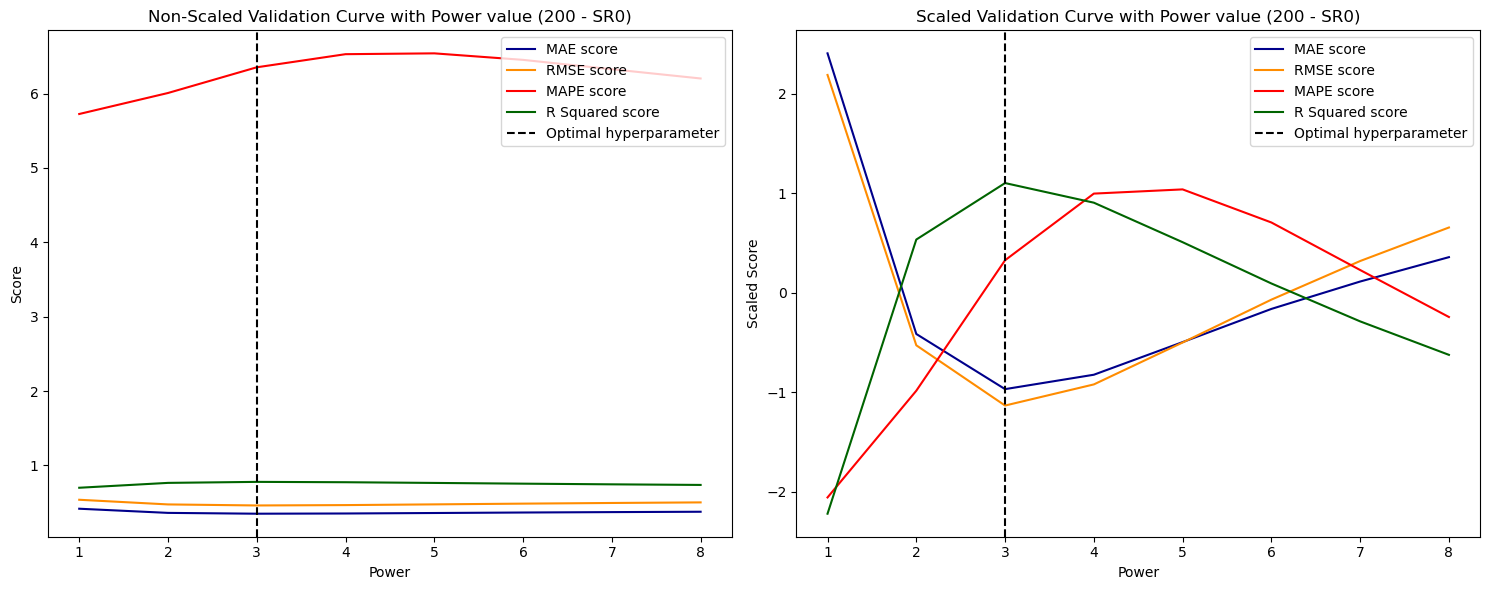

In [5]:
power = 3
df = pd.DataFrame(cv_score_list_200_power).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(powers_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(powers_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(powers_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(powers_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('Power')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with Power value (200 - SR0)")

# Plot normalized data on the second subplot
ax[1].plot(powers_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(powers_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(powers_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(powers_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('Power')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with Power value (200 - SR0)")

plt.tight_layout()
plt.show()

In [6]:
# Initialize an empty dictionary for storing scores
cv_score_list_200_n = {}
n_neighbors_list = np.arange(1,61,3)

start_time = time.time()

# For each number of neighbors
for n_neighbors in n_neighbors_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=3, n_neighbors=n_neighbors)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_200_n[n_neighbors] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_200_n))

# Identifying the best number of neighbors based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_200_n.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,4,7,10,13,16,19,22,25,28,31,34,37,40,43,46,49,52,55,58
Validation Score MAE,0.427749,0.358277,0.353063,0.350271,0.350670,0.351155,0.352633,0.354188,0.355634,0.356863,0.358022,0.358977,0.359554,0.359989,0.360426,0.360745,0.361132,0.361368,0.361526,0.361706
Validation Score RMSE,0.581790,0.474894,0.465355,0.460387,0.460511,0.461161,0.463204,0.465384,0.467361,0.468967,0.470514,0.471741,0.472459,0.473106,0.473693,0.474152,0.474689,0.474992,0.475192,0.475436
Validation Score MAPE,6.426382,6.954401,6.454911,6.501934,6.420403,6.390403,6.284405,6.275765,6.210735,6.178534,6.120171,6.112726,6.126040,6.128881,6.107563,6.107013,6.126216,6.122758,6.133252,6.139072
Validation Score R Squared,0.651577,0.767851,0.777083,0.781817,0.781700,0.781083,0.779139,0.777055,0.775157,0.773609,0.772113,0.770923,0.770226,0.769595,0.769023,0.768576,0.768051,0.767755,0.767559,0.767321


The smallest Validation Score MAE is 0.35027086263531576, found in n_neighbors 10.
The smallest Validation Score RMSE is 0.4603870957512271, found in n_neighbors 10.
The smallest Validation Score MAPE is 6.107013352276342, found in n_neighbors 46.
The largest Validation Score R Squared is 0.7818173249804312, found in n_neighbors 10.
Validation Computation Time: 1.15 seconds


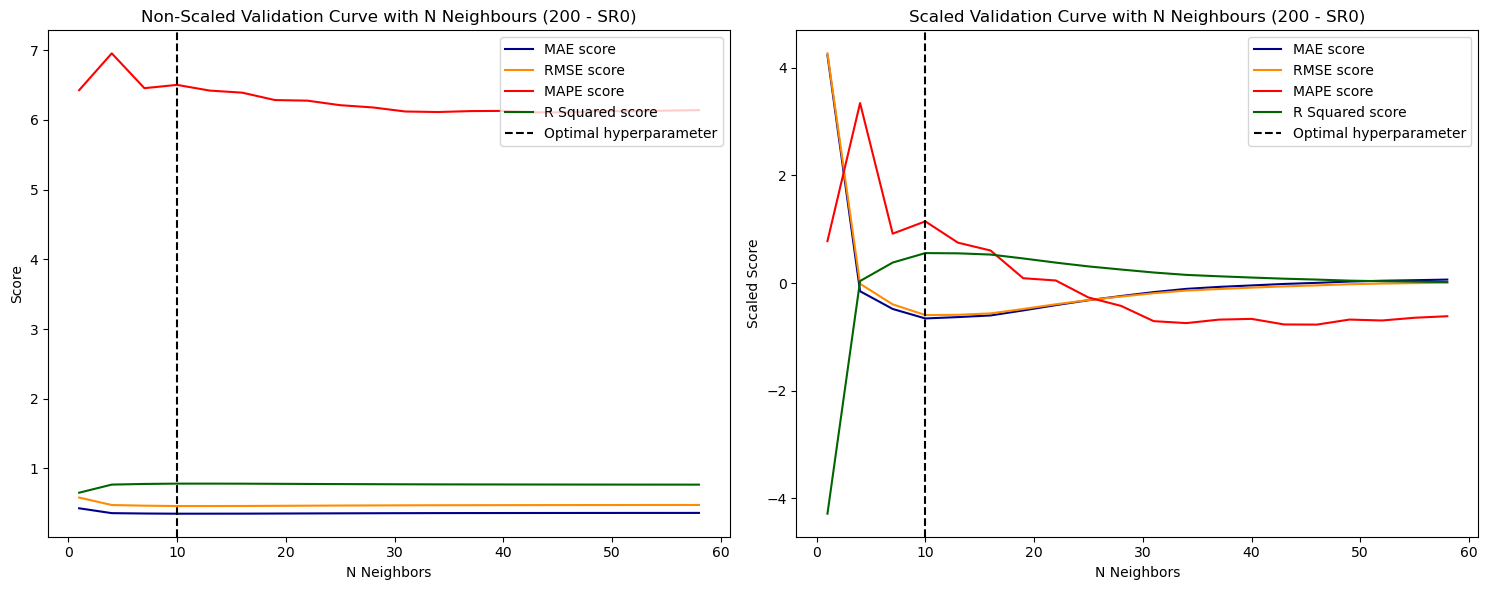

In [7]:
n_neighbors = 10
df = pd.DataFrame(cv_score_list_200_n).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(n_neighbors_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(n_neighbors_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(n_neighbors_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(n_neighbors_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('N Neighbors')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with N Neighbours (200 - SR0)")

# Plot normalized data on the second subplot
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('N Neighbors')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with N Neighbours (200 - SR0)")

plt.tight_layout()
plt.show()

# 400 points calibration

In [8]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR0_input_randomfield_cal400.csv')
val_df = pd.read_csv(f'{file_path}val_SR0_input_randomfield_cal400.csv')
test_df = pd.read_csv(f'{file_path}test_SR0_input_randomfield_cal400.csv')

In [9]:
# Initialize an empty dictionary for storing scores
cv_score_list_400_power = {}
powers_list = [1, 2, 3, 4, 5, 6, 7, 8]

start_time = time.time()

# For each hyperparameter value
for power in powers_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=power)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_400_power[power] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_400_power))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_400_power.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in power {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in power {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,2,3,4,5,6,7,8
Validation Score MAE,0.319631,0.268116,0.253036,0.254009,0.259402,0.264994,0.269815,0.273999
Validation Score RMSE,0.425540,0.366829,0.347484,0.346846,0.352498,0.359601,0.366518,0.372766
Validation Score MAPE,5.748263,4.808975,4.541113,4.483841,4.525609,4.606504,4.693767,4.773925
Validation Score R Squared,0.813596,0.861484,0.875708,0.876164,0.872095,0.866889,0.861718,0.856963


The smallest Validation Score MAE is 0.25303636660927387, found in power 3.
The smallest Validation Score RMSE is 0.34684567737446115, found in power 4.
The smallest Validation Score MAPE is 4.483841171979439, found in power 4.
The largest Validation Score R Squared is 0.8761641041009536, found in power 4.
Validation Computation Time: 0.48 seconds


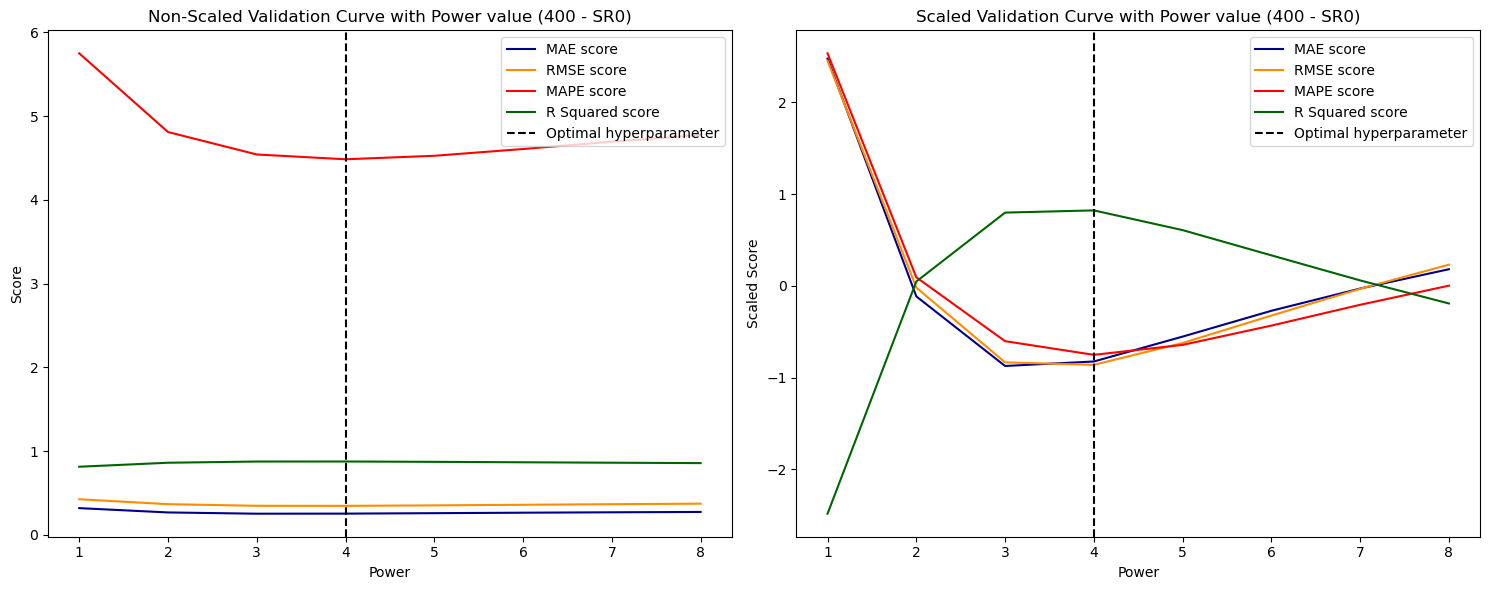

In [10]:
power = 4
df = pd.DataFrame(cv_score_list_400_power).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(powers_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(powers_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(powers_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(powers_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('Power')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with Power value (400 - SR0)")

# Plot normalized data on the second subplot
ax[1].plot(powers_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(powers_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(powers_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(powers_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('Power')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with Power value (400 - SR0)")

plt.tight_layout()
plt.show()

In [11]:
# Initialize an empty dictionary for storing scores
cv_score_list_400_n = {}
n_neighbors_list = np.arange(1,61,3)

start_time = time.time()

# For each number of neighbors
for n_neighbors in n_neighbors_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=4, n_neighbors=n_neighbors)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_400_n[n_neighbors] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_400_n))

# Identifying the best number of neighbors based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_400_n.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,4,7,10,13,16,19,22,25,28,31,34,37,40,43,46,49,52,55,58
Validation Score MAE,0.316163,0.257090,0.253929,0.253743,0.253639,0.253169,0.252885,0.252746,0.252750,0.252835,0.252941,0.252987,0.253062,0.253116,0.253157,0.253192,0.253231,0.253290,0.253336,0.253383
Validation Score RMSE,0.437632,0.350901,0.346791,0.346851,0.346687,0.345739,0.345312,0.345002,0.344967,0.345052,0.345156,0.345109,0.345162,0.345177,0.345215,0.345233,0.345269,0.345322,0.345356,0.345420
Validation Score MAPE,5.481249,4.432380,4.470922,4.478018,4.477357,4.477152,4.483238,4.485312,4.486228,4.489077,4.492645,4.493955,4.494625,4.495100,4.495192,4.495386,4.496452,4.496634,4.496682,4.496989
Validation Score R Squared,0.802852,0.873251,0.876203,0.876160,0.876277,0.876953,0.877257,0.877477,0.877502,0.877441,0.877368,0.877401,0.877364,0.877353,0.877326,0.877313,0.877287,0.877250,0.877225,0.877180


The smallest Validation Score MAE is 0.25274563653546644, found in n_neighbors 22.
The smallest Validation Score RMSE is 0.34496654491496165, found in n_neighbors 25.
The smallest Validation Score MAPE is 4.432379594665425, found in n_neighbors 4.
The largest Validation Score R Squared is 0.8775022997162905, found in n_neighbors 25.
Validation Computation Time: 1.56 seconds


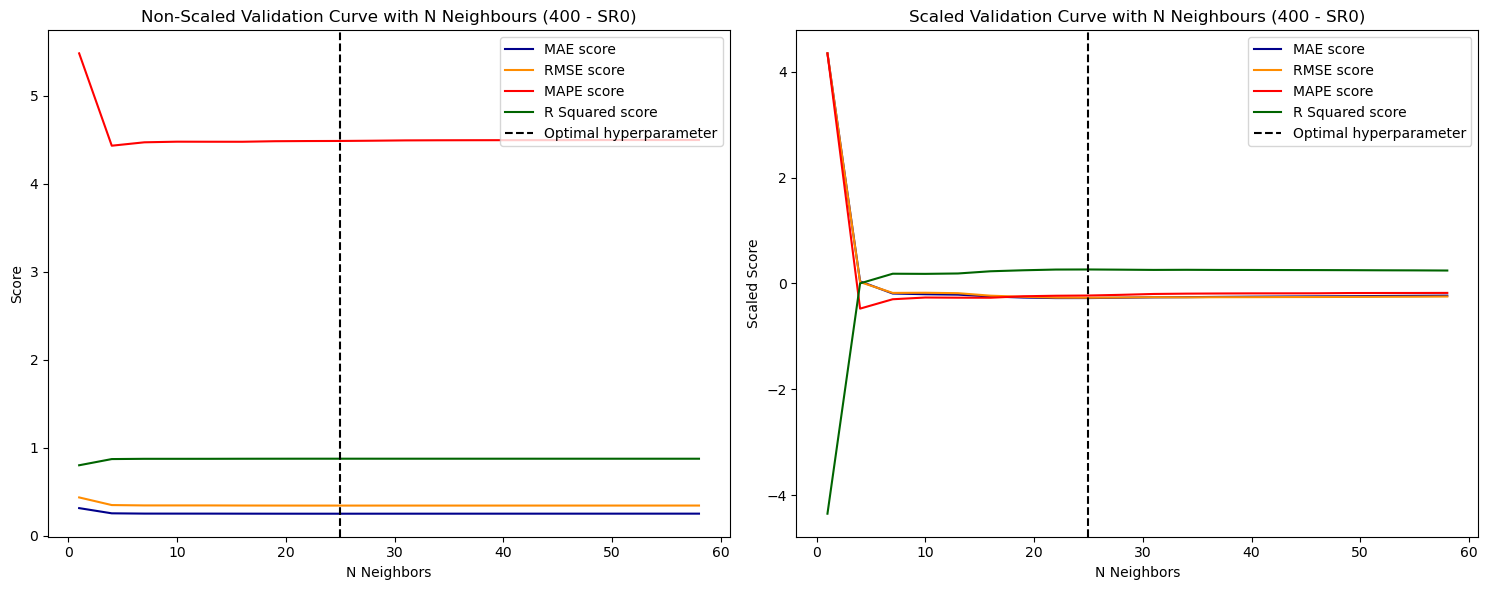

In [12]:
n_neighbors = 25
df = pd.DataFrame(cv_score_list_400_n).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(n_neighbors_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(n_neighbors_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(n_neighbors_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(n_neighbors_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('N Neighbors')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with N Neighbours (400 - SR0)")

# Plot normalized data on the second subplot
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('N Neighbors')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with N Neighbours (400 - SR0)")

plt.tight_layout()
plt.show()

# 600 points calibration

In [13]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR0_input_randomfield_cal600.csv')
val_df = pd.read_csv(f'{file_path}val_SR0_input_randomfield_cal600.csv')
test_df = pd.read_csv(f'{file_path}test_SR0_input_randomfield_cal600.csv')

In [14]:
# Initialize an empty dictionary for storing scores
cv_score_list_600_power = {}
powers_list = [1, 2, 3, 4, 5, 6, 7, 8]

start_time = time.time()

# For each hyperparameter value
for power in powers_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=power)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_600_power[power] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_600_power))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_600_power.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in power {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in power {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,2,3,4,5,6,7,8
Validation Score MAE,0.267914,0.224012,0.211785,0.213489,0.218442,0.223336,0.227360,0.230850
Validation Score RMSE,0.358790,0.307339,0.289225,0.288380,0.293565,0.300102,0.306388,0.311957
Validation Score MAPE,4.959848,4.314009,4.108099,4.137594,4.265509,4.406144,4.536089,4.647388
Validation Score R Squared,0.867488,0.902768,0.913891,0.914394,0.911288,0.907293,0.903369,0.899824


The smallest Validation Score MAE is 0.21178546355375188, found in power 3.
The smallest Validation Score RMSE is 0.28837981436588495, found in power 4.
The smallest Validation Score MAPE is 4.108098654738066, found in power 3.
The largest Validation Score R Squared is 0.9143941007874886, found in power 4.
Validation Computation Time: 0.49 seconds


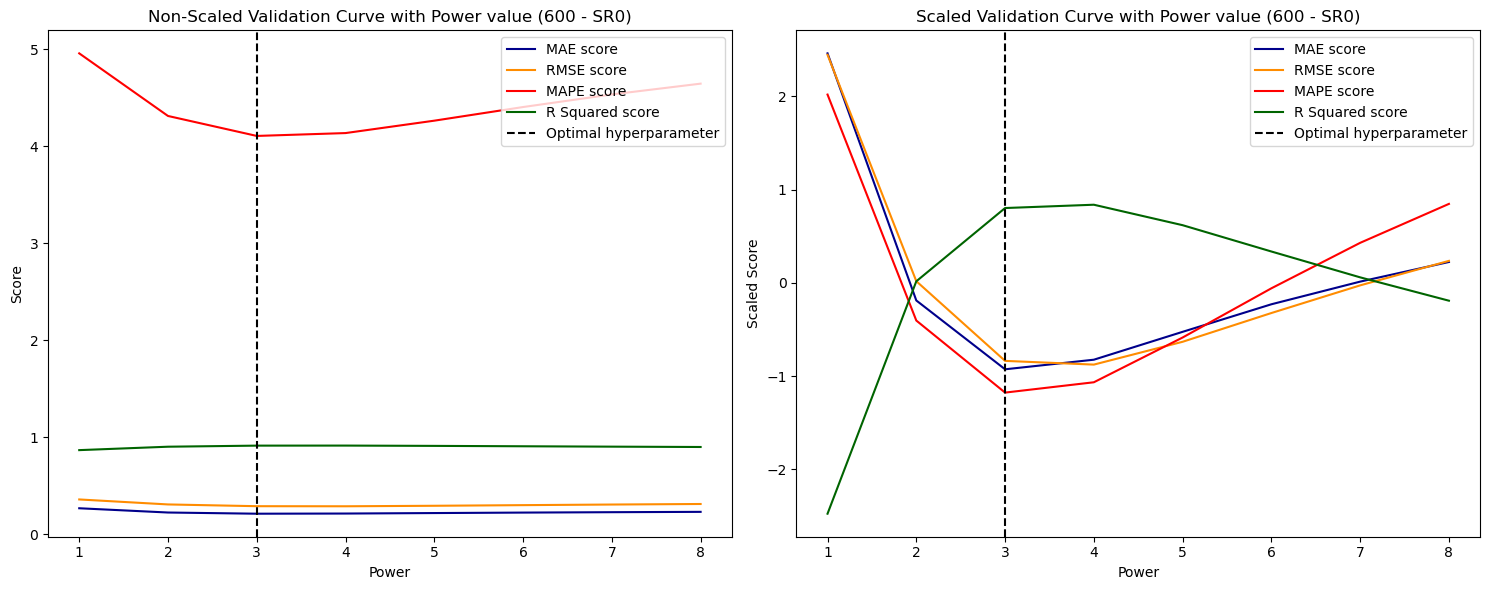

In [15]:
power = 3
df = pd.DataFrame(cv_score_list_600_power).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(powers_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(powers_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(powers_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(powers_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('Power')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with Power value (600 - SR0)")

# Plot normalized data on the second subplot
ax[1].plot(powers_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(powers_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(powers_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(powers_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('Power')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with Power value (600 - SR0)")

plt.tight_layout()
plt.show()

In [16]:
# Initialize an empty dictionary for storing scores
cv_score_list_600_n = {}
n_neighbors_list = np.arange(1,61,3)

start_time = time.time()

# For each number of neighbors
for n_neighbors in n_neighbors_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=3, n_neighbors=n_neighbors)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_600_n[n_neighbors] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_600_n))

# Identifying the best number of neighbors based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_600_n.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,4,7,10,13,16,19,22,25,28,31,34,37,40,43,46,49,52,55,58
Validation Score MAE,0.265402,0.213172,0.210791,0.213930,0.215809,0.216742,0.217847,0.218526,0.219413,0.219929,0.220533,0.220908,0.221371,0.221902,0.222362,0.222811,0.223244,0.223625,0.223988,0.224271
Validation Score RMSE,0.364937,0.290639,0.288002,0.292903,0.296128,0.297755,0.299284,0.300753,0.302250,0.303147,0.303996,0.304555,0.305302,0.306055,0.306719,0.307407,0.307965,0.308470,0.308981,0.309376
Validation Score MAPE,5.191622,4.185784,4.007594,4.378727,4.483634,4.490044,4.513297,4.514484,4.536582,4.568139,4.578360,4.573572,4.588321,4.609175,4.621201,4.628950,4.633319,4.642464,4.649247,4.656336
Validation Score R Squared,0.862909,0.913048,0.914618,0.911688,0.909732,0.908738,0.907798,0.906891,0.905961,0.905403,0.904872,0.904522,0.904053,0.903579,0.903160,0.902725,0.902372,0.902051,0.901726,0.901475


The smallest Validation Score MAE is 0.21079118015728046, found in n_neighbors 7.
The smallest Validation Score RMSE is 0.28800213421957616, found in n_neighbors 7.
The smallest Validation Score MAPE is 4.007593923746101, found in n_neighbors 7.
The largest Validation Score R Squared is 0.9146181835780356, found in n_neighbors 7.
Validation Computation Time: 1.44 seconds


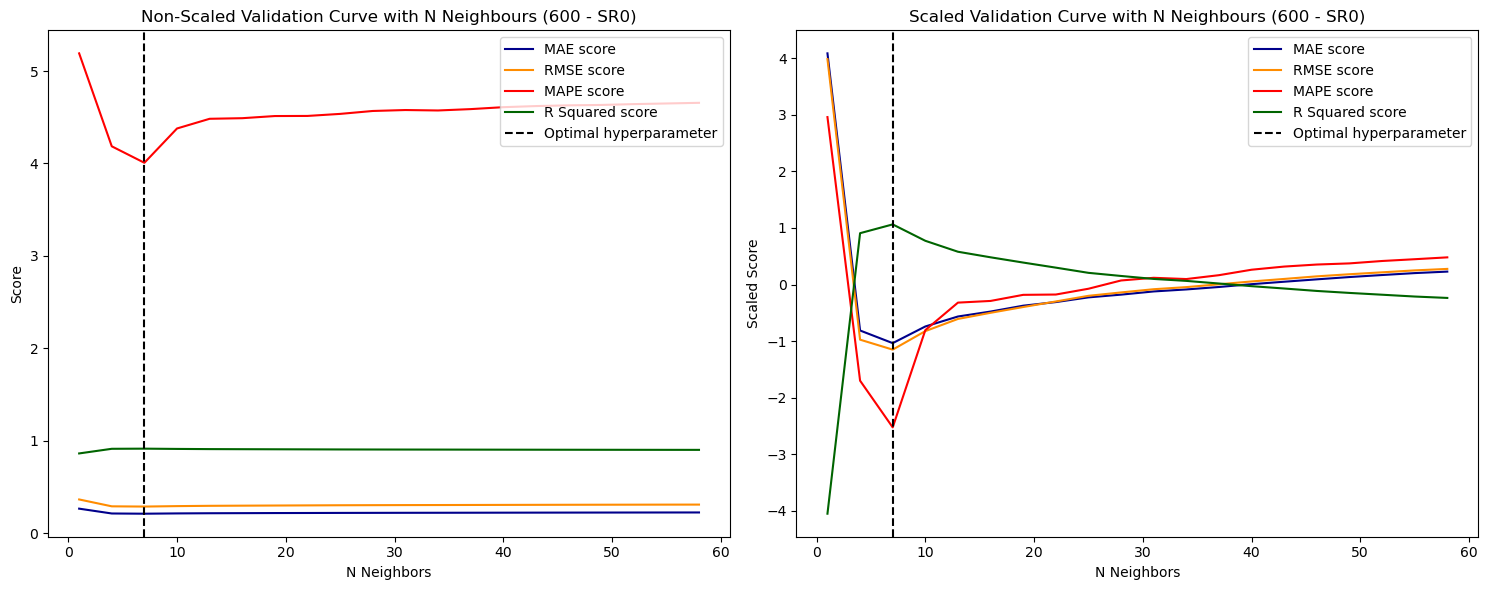

In [17]:
n_neighbors = 7
df = pd.DataFrame(cv_score_list_600_n).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(n_neighbors_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(n_neighbors_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(n_neighbors_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(n_neighbors_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('N Neighbors')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with N Neighbours (600 - SR0)")

# Plot normalized data on the second subplot
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('N Neighbors')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with N Neighbours (600 - SR0)")

plt.tight_layout()
plt.show()

# 800 points calibration

In [18]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR0_input_randomfield_cal800.csv')
val_df = pd.read_csv(f'{file_path}val_SR0_input_randomfield_cal800.csv')
test_df = pd.read_csv(f'{file_path}test_SR0_input_randomfield_cal800.csv')

In [19]:
# Initialize an empty dictionary for storing scores
cv_score_list_800_power = {}
powers_list = [1, 2, 3, 4, 5, 6, 7, 8]

start_time = time.time()

# For each hyperparameter value
for power in powers_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=power)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_800_power[power] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_800_power))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_800_power.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in power {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in power {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,2,3,4,5,6,7,8
Validation Score MAE,0.233942,0.197229,0.187073,0.188277,0.192399,0.196781,0.200713,0.204123
Validation Score RMSE,0.311586,0.268877,0.254538,0.254190,0.258711,0.264484,0.270181,0.275350
Validation Score MAPE,3.320721,2.293869,1.608253,2.009316,2.436542,2.746562,2.975605,3.148116
Validation Score R Squared,0.900062,0.925582,0.933307,0.933489,0.931102,0.927993,0.924858,0.921955


The smallest Validation Score MAE is 0.18707292736027276, found in power 3.
The smallest Validation Score RMSE is 0.25419013460447515, found in power 4.
The smallest Validation Score MAPE is 1.6082531747915263, found in power 3.
The largest Validation Score R Squared is 0.933489324319914, found in power 4.
Validation Computation Time: 0.52 seconds


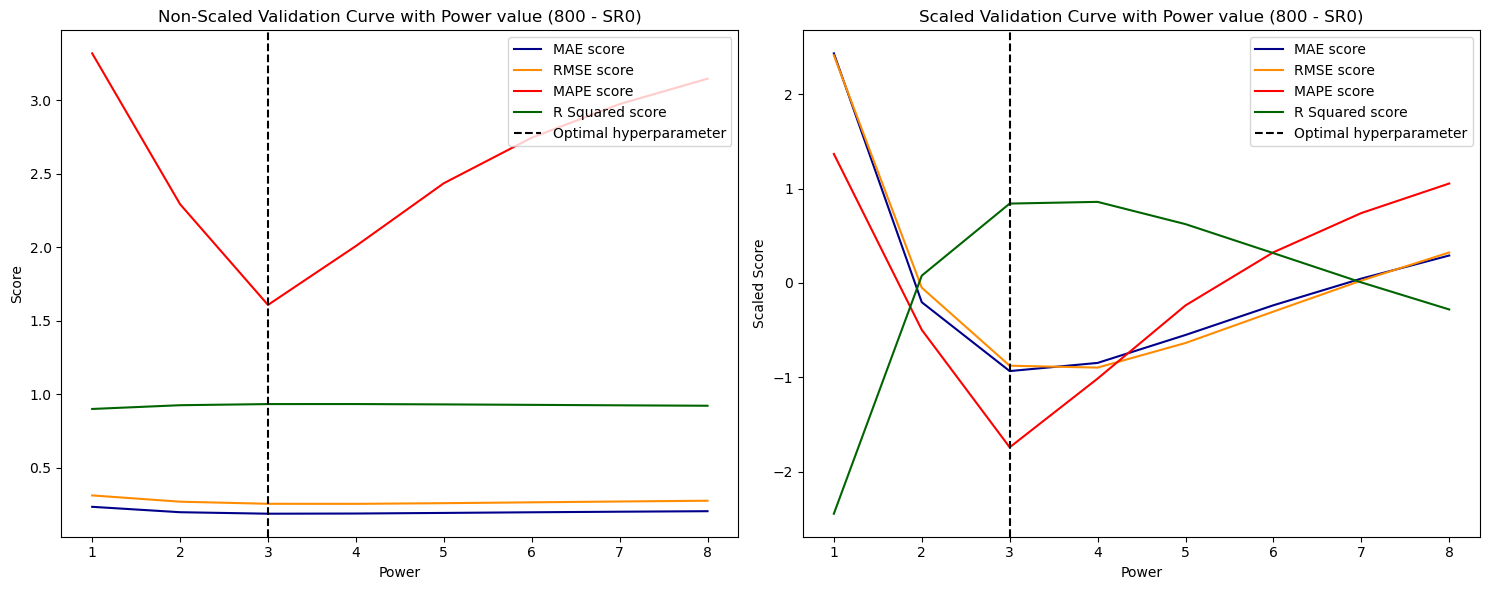

In [20]:
power = 3
df = pd.DataFrame(cv_score_list_800_power).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(powers_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(powers_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(powers_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(powers_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('Power')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with Power value (800 - SR0)")

# Plot normalized data on the second subplot
ax[1].plot(powers_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(powers_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(powers_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(powers_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('Power')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with Power value (800 - SR0)")

plt.tight_layout()
plt.show()

In [21]:
# Initialize an empty dictionary for storing scores
cv_score_list_800_n = {}
n_neighbors_list = np.arange(1,61,3)

start_time = time.time()

# For each number of neighbors
for n_neighbors in n_neighbors_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=3, n_neighbors=n_neighbors)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_800_n[n_neighbors] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_800_n))

# Identifying the best number of neighbors based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_800_n.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,4,7,10,13,16,19,22,25,28,31,34,37,40,43,46,49,52,55,58
Validation Score MAE,0.238680,0.186923,0.186200,0.188310,0.190409,0.192758,0.194005,0.195404,0.196594,0.197542,0.198245,0.198991,0.199516,0.200074,0.200560,0.200976,0.201440,0.201812,0.202153,0.202488
Validation Score RMSE,0.325922,0.255633,0.253624,0.255889,0.258888,0.262258,0.264188,0.266143,0.267718,0.269243,0.270293,0.271390,0.272190,0.273031,0.273683,0.274310,0.274978,0.275599,0.276122,0.276642
Validation Score MAPE,3.853649,1.917823,1.570181,1.846805,2.042450,2.182776,2.254776,2.288456,2.328815,2.369232,2.376297,2.408277,2.438002,2.445606,2.450461,2.472313,2.468404,2.485714,2.494345,2.494475
Validation Score R Squared,0.890654,0.932732,0.933785,0.932597,0.931008,0.929200,0.928155,0.927087,0.926222,0.925379,0.924796,0.924184,0.923736,0.923264,0.922897,0.922544,0.922166,0.921814,0.921517,0.921221


The smallest Validation Score MAE is 0.1861997623354012, found in n_neighbors 7.
The smallest Validation Score RMSE is 0.2536241458703741, found in n_neighbors 7.
The smallest Validation Score MAPE is 1.5701810257910573, found in n_neighbors 7.
The largest Validation Score R Squared is 0.9337851846068159, found in n_neighbors 7.
Validation Computation Time: 1.38 seconds


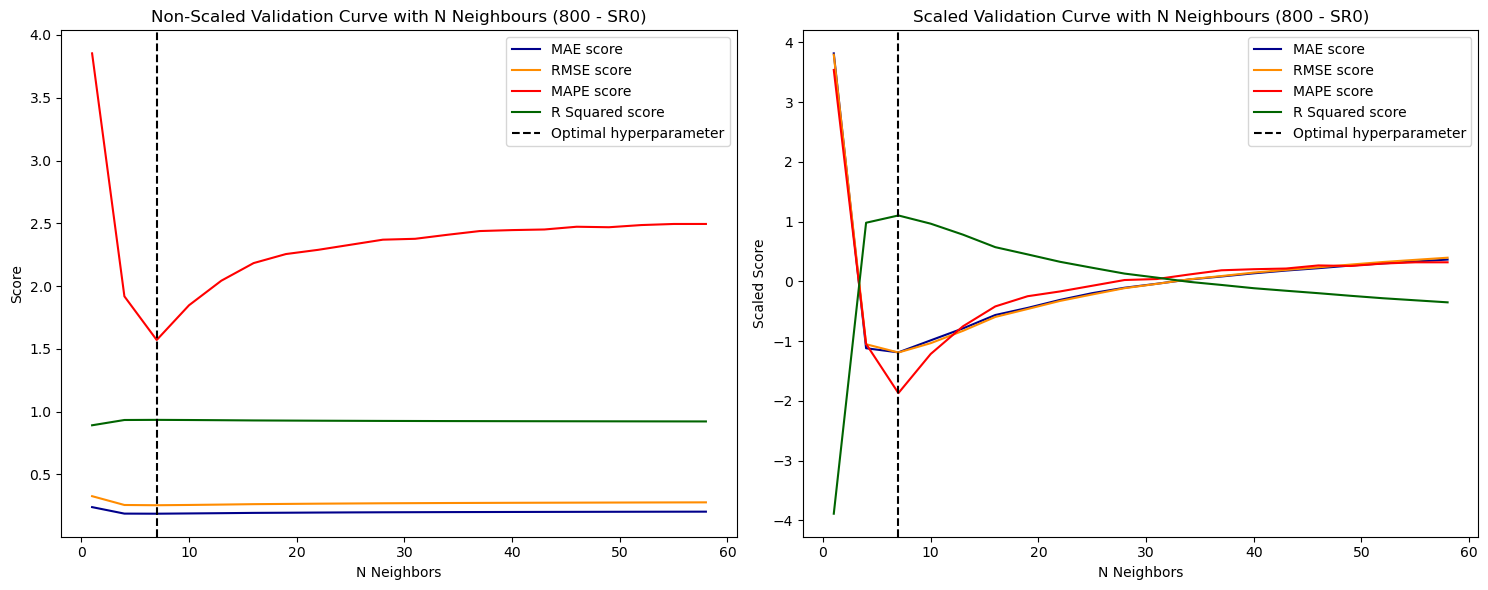

In [22]:
n_neighbors = 7
df = pd.DataFrame(cv_score_list_800_n).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(n_neighbors_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(n_neighbors_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(n_neighbors_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(n_neighbors_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('N Neighbors')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with N Neighbours (800 - SR0)")

# Plot normalized data on the second subplot
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('N Neighbors')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with N Neighbours (800 - SR0)")

plt.tight_layout()
plt.show()

# 1000 points calibration

In [23]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR0_input_randomfield_cal1000.csv')
val_df = pd.read_csv(f'{file_path}val_SR0_input_randomfield_cal1000.csv')
test_df = pd.read_csv(f'{file_path}test_SR0_input_randomfield_cal1000.csv')

In [24]:
# Initialize an empty dictionary for storing scores
cv_score_list_1000_power = {}
powers_list = [1, 2, 3, 4, 5, 6, 7, 8]

start_time = time.time()

# For each hyperparameter value
for power in powers_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=power)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_1000_power[power] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1000_power))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_1000_power.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in power {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in power {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,2,3,4,5,6,7,8
Validation Score MAE,0.203728,0.170774,0.161955,0.164453,0.169590,0.174825,0.179082,0.182543
Validation Score RMSE,0.268639,0.229952,0.218196,0.220365,0.227044,0.234392,0.241089,0.246803
Validation Score MAPE,2.970432,2.091275,1.489601,1.812941,2.267403,2.600108,2.842761,3.021525
Validation Score R Squared,0.925713,0.945569,0.950992,0.950013,0.946937,0.943447,0.940169,0.937299


The smallest Validation Score MAE is 0.16195509228052243, found in power 3.
The smallest Validation Score RMSE is 0.21819585344597847, found in power 3.
The smallest Validation Score MAPE is 1.4896013114352484, found in power 3.
The largest Validation Score R Squared is 0.950992001768565, found in power 3.
Validation Computation Time: 0.43 seconds


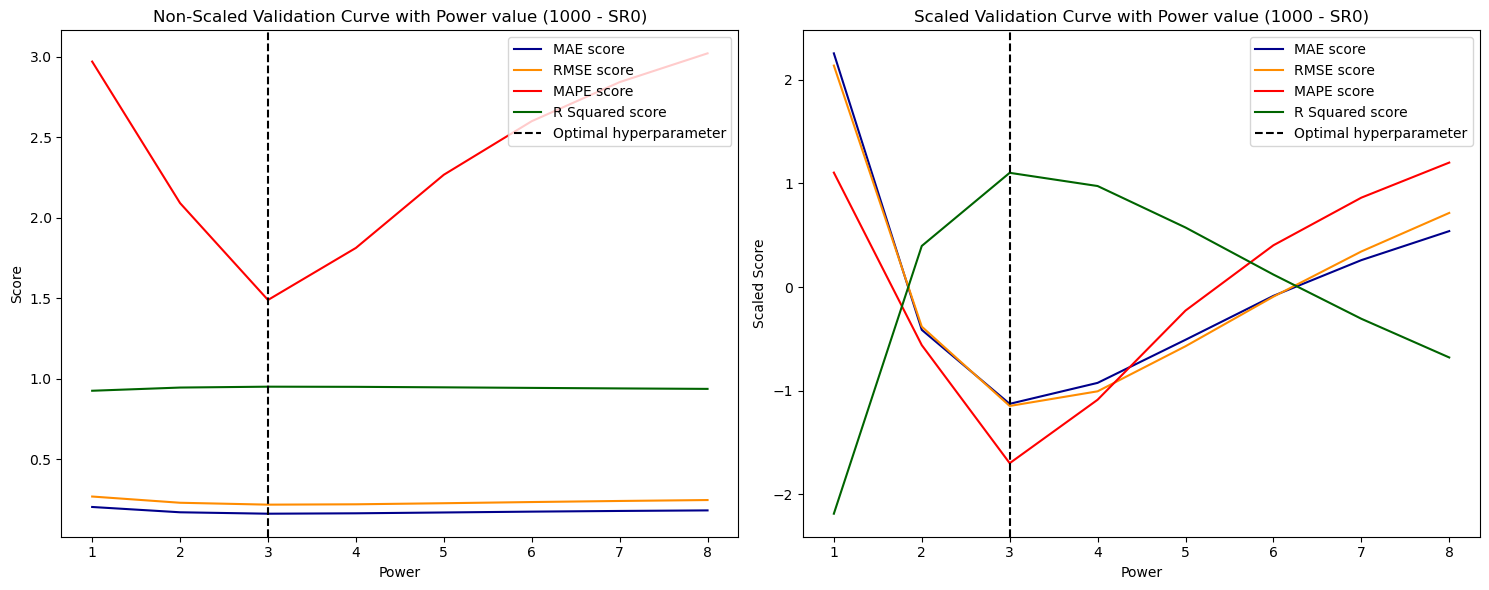

In [25]:
power = 3
df = pd.DataFrame(cv_score_list_1000_power).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(powers_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(powers_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(powers_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(powers_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('Power')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with Power value (1000 - SR0)")

# Plot normalized data on the second subplot
ax[1].plot(powers_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(powers_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(powers_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(powers_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('Power')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with Power value (1000 - SR0)")

plt.tight_layout()
plt.show()

In [26]:
# Initialize an empty dictionary for storing scores
cv_score_list_1000_n = {}
n_neighbors_list = np.arange(1,61,3)

start_time = time.time()

# For each number of neighbors
for n_neighbors in n_neighbors_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=3, n_neighbors=n_neighbors)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_1000_n[n_neighbors] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1000_n))  # Transposed for better readability

# Identifying the best number of neighbors based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_1000_n.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,4,7,10,13,16,19,22,25,28,31,34,37,40,43,46,49,52,55,58
Validation Score MAE,0.218108,0.162912,0.161419,0.163930,0.166194,0.168720,0.170790,0.172617,0.174033,0.175183,0.176404,0.177352,0.178235,0.178946,0.179630,0.180285,0.180856,0.181373,0.181781,0.182238
Validation Score RMSE,0.295400,0.220586,0.217616,0.220779,0.223826,0.227446,0.230400,0.232844,0.234731,0.236263,0.237951,0.239281,0.240562,0.241537,0.242469,0.243396,0.244190,0.244973,0.245609,0.246263
Validation Score MAPE,3.698228,1.828925,1.538112,1.786816,1.947717,2.093817,2.180069,2.244631,2.284651,2.307505,2.346978,2.372761,2.397518,2.407116,2.439107,2.444289,2.454635,2.464689,2.470185,2.485471
Validation Score R Squared,0.910176,0.949912,0.951252,0.949825,0.948430,0.946748,0.945357,0.944191,0.943283,0.942540,0.941716,0.941063,0.940430,0.939946,0.939482,0.939018,0.938619,0.938225,0.937904,0.937573


The smallest Validation Score MAE is 0.1614193473882314, found in n_neighbors 7.
The smallest Validation Score RMSE is 0.21761579676279041, found in n_neighbors 7.
The smallest Validation Score MAPE is 1.5381117255526515, found in n_neighbors 7.
The largest Validation Score R Squared is 0.9512522233119033, found in n_neighbors 7.
Validation Computation Time: 1.87 seconds


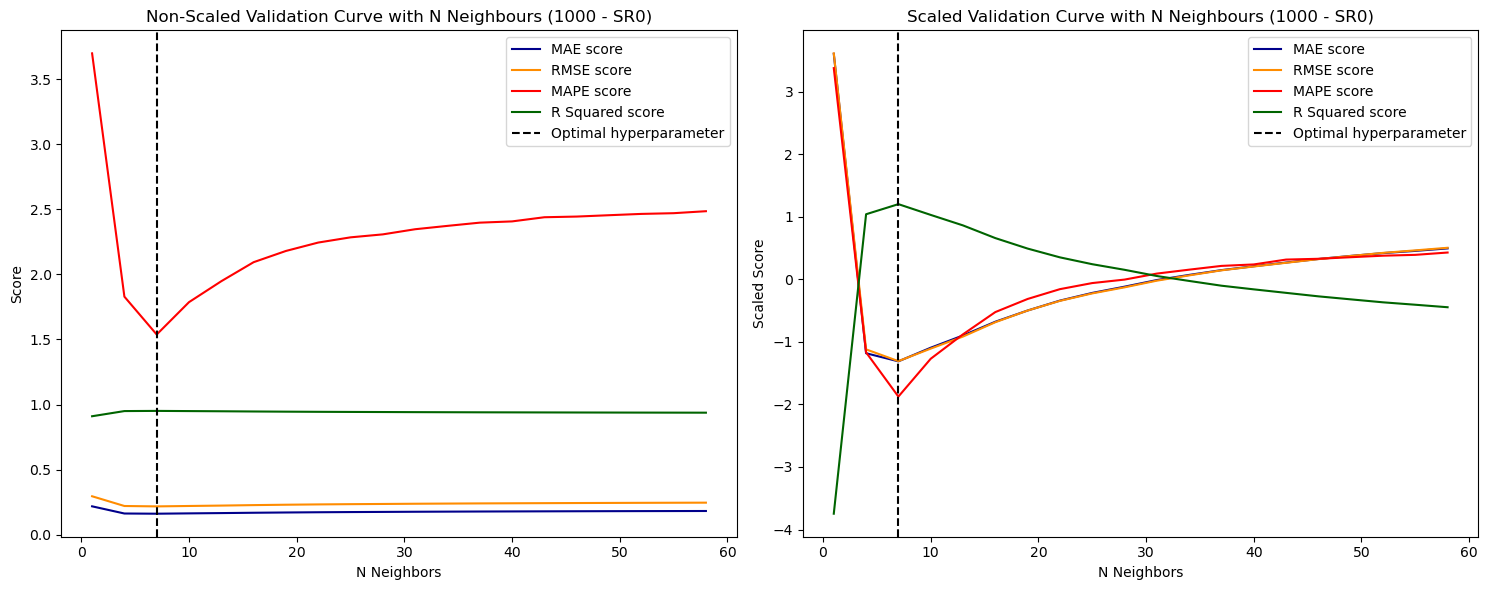

In [27]:
n_neighbors = 7
df = pd.DataFrame(cv_score_list_1000_n).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(n_neighbors_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(n_neighbors_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(n_neighbors_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(n_neighbors_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('N Neighbors')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with N Neighbours (1000 - SR0)")

# Plot normalized data on the second subplot
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('N Neighbors')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with N Neighbours (1000 - SR0)")

plt.tight_layout()
plt.show()

# 1500 points calibration

In [28]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR0_input_randomfield_cal1500.csv')
val_df = pd.read_csv(f'{file_path}val_SR0_input_randomfield_cal1500.csv')
test_df = pd.read_csv(f'{file_path}test_SR0_input_randomfield_cal1500.csv')

In [29]:
# Initialize an empty dictionary for storing scores
cv_score_list_1500_power = {}
powers_list = [1, 2, 3, 4, 5, 6, 7, 8]

start_time = time.time()

# For each hyperparameter value
for power in powers_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=power)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_1500_power[power] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1500_power))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_1500_power.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in power {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in power {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,2,3,4,5,6,7,8
Validation Score MAE,0.165819,0.141421,0.133782,0.135853,0.140220,0.144597,0.148249,0.150997
Validation Score RMSE,0.221302,0.192921,0.183682,0.185369,0.190623,0.196258,0.201212,0.205261
Validation Score MAPE,2.654874,2.259560,2.131863,2.201165,2.344921,2.497935,2.632245,2.740646
Validation Score R Squared,0.949587,0.961688,0.965270,0.964629,0.962595,0.960351,0.958324,0.956630


The smallest Validation Score MAE is 0.13378227749858707, found in power 3.
The smallest Validation Score RMSE is 0.18368226794350492, found in power 3.
The smallest Validation Score MAPE is 2.1318625953945456, found in power 3.
The largest Validation Score R Squared is 0.9652697072825738, found in power 3.
Validation Computation Time: 0.44 seconds


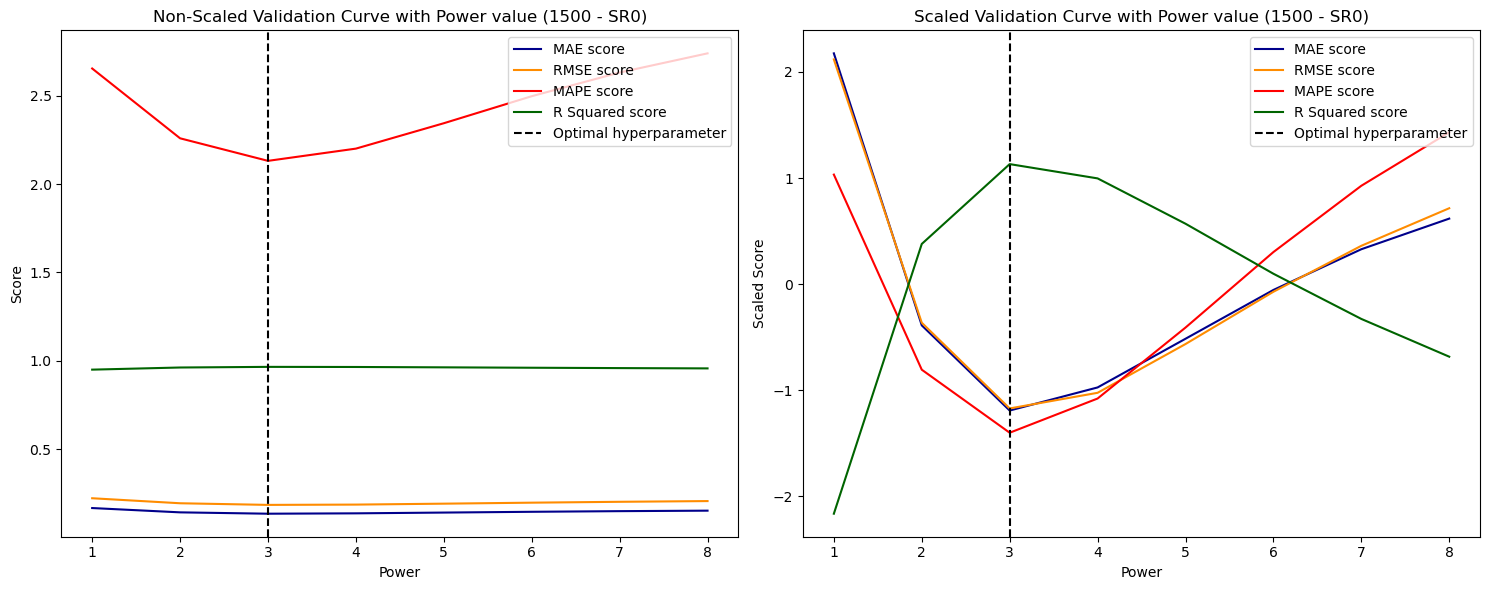

In [30]:
power = 3
df = pd.DataFrame(cv_score_list_1500_power).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(powers_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(powers_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(powers_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(powers_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('Power')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with Power value (1500 - SR0)")

# Plot normalized data on the second subplot
ax[1].plot(powers_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(powers_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(powers_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(powers_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('Power')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with Power value (1500 - SR0)")

plt.tight_layout()
plt.show()

In [31]:
# Initialize an empty dictionary for storing scores
cv_score_list_1500_n = {}
n_neighbors_list = np.arange(1,61,3)

start_time = time.time()

# For each number of neighbors
for n_neighbors in n_neighbors_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=3, n_neighbors=n_neighbors)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_1500_n[n_neighbors] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1500_n))  # Transposed for better readability

# Identifying the best number of neighbors based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_1500_n.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,4,7,10,13,16,19,22,25,28,31,34,37,40,43,46,49,52,55,58
Validation Score MAE,0.186623,0.134687,0.133404,0.134970,0.137256,0.139726,0.141897,0.143730,0.145606,0.147220,0.148588,0.149880,0.150986,0.151957,0.152847,0.153669,0.154444,0.155106,0.155736,0.156309
Validation Score RMSE,0.252880,0.187781,0.182783,0.185228,0.187663,0.190689,0.193376,0.195579,0.197772,0.199658,0.201463,0.203081,0.204419,0.205632,0.206824,0.207929,0.209035,0.209868,0.210763,0.211529
Validation Score MAPE,3.314453,2.104913,2.158447,2.148784,2.247642,2.388648,2.461665,2.514135,2.563442,2.589755,2.617491,2.614550,2.631702,2.647655,2.658154,2.670683,2.688639,2.696967,2.703564,2.712701
Validation Score R Squared,0.934173,0.963703,0.965609,0.964683,0.963748,0.962570,0.961507,0.960625,0.959737,0.958966,0.958220,0.957547,0.956985,0.956473,0.955967,0.955495,0.955021,0.954661,0.954274,0.953941


The smallest Validation Score MAE is 0.13340418005671575, found in n_neighbors 7.
The smallest Validation Score RMSE is 0.18278337323047023, found in n_neighbors 7.
The smallest Validation Score MAPE is 2.1049134468234234, found in n_neighbors 4.
The largest Validation Score R Squared is 0.965608798128945, found in n_neighbors 7.
Validation Computation Time: 1.21 seconds


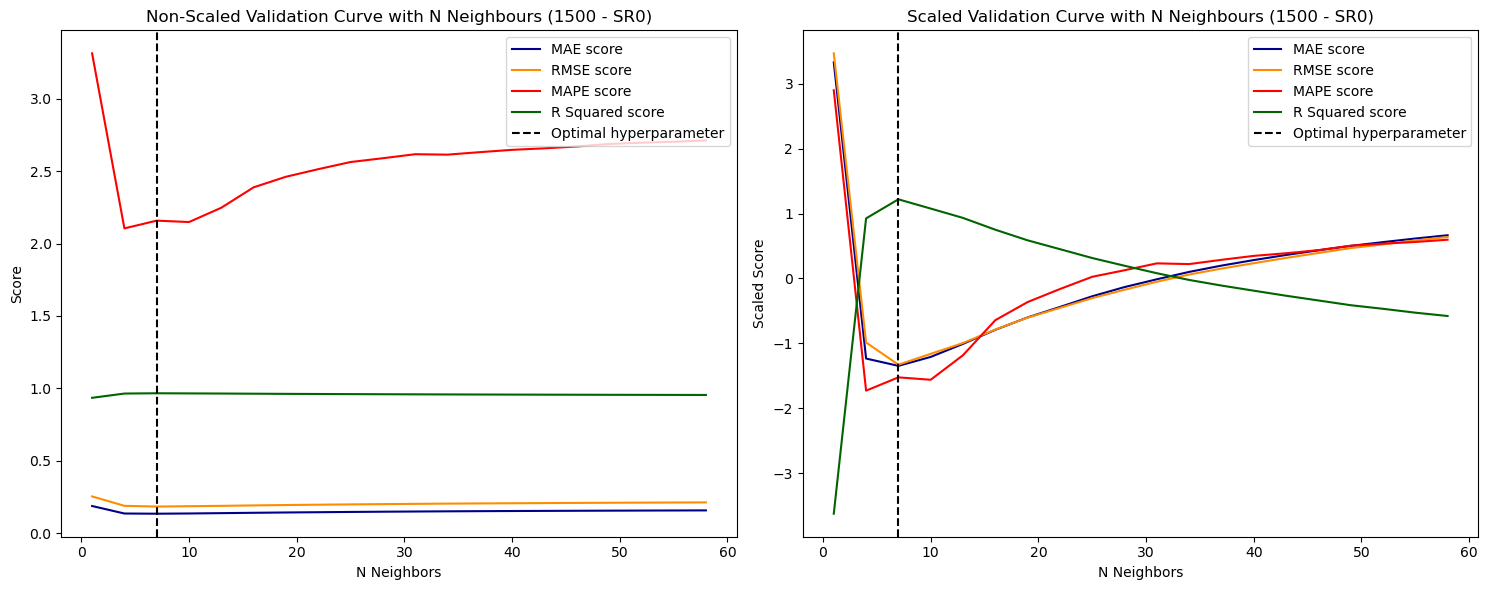

In [32]:
n_neighbors = 7
df = pd.DataFrame(cv_score_list_1500_n).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(n_neighbors_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(n_neighbors_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(n_neighbors_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(n_neighbors_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('N Neighbors')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with N Neighbours (1500 - SR0)")

# Plot normalized data on the second subplot
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('N Neighbors')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with N Neighbours (1500 - SR0)")

plt.tight_layout()
plt.show()

# 2000 points calibration

In [33]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR0_input_randomfield_cal2000.csv')
val_df = pd.read_csv(f'{file_path}val_SR0_input_randomfield_cal2000.csv')
test_df = pd.read_csv(f'{file_path}test_SR0_input_randomfield_cal2000.csv')

In [34]:
# Initialize an empty dictionary for storing scores
cv_score_list_2000_power = {}
powers_list = [1, 2, 3, 4, 5, 6, 7, 8]

start_time = time.time()

# For each hyperparameter value
for power in powers_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=power)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_2000_power[power] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_2000_power))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_2000_power.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in power {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in power {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,2,3,4,5,6,7,8
Validation Score MAE,0.139822,0.120134,0.114083,0.116012,0.120222,0.124257,0.127568,0.130131
Validation Score RMSE,0.182698,0.159773,0.152734,0.155047,0.160089,0.165146,0.169476,0.172984
Validation Score MAPE,2.264716,2.012695,1.945159,2.018163,2.155800,2.306468,2.446638,2.565867
Validation Score R Squared,0.965641,0.973723,0.975987,0.975254,0.973619,0.971926,0.970434,0.969197


The smallest Validation Score MAE is 0.11408308628195891, found in power 3.
The smallest Validation Score RMSE is 0.15273436358755033, found in power 3.
The smallest Validation Score MAPE is 1.9451592857155857, found in power 3.
The largest Validation Score R Squared is 0.9759869405039382, found in power 3.
Validation Computation Time: 0.45 seconds


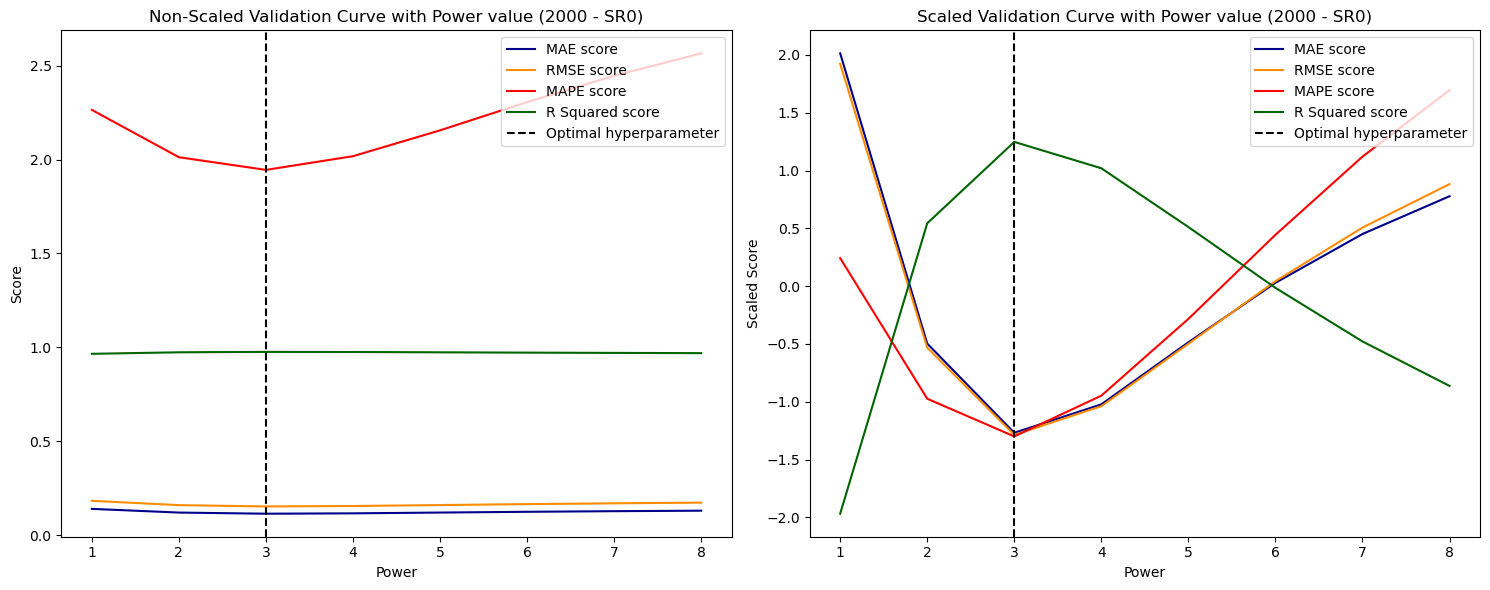

In [35]:
power = 3
df = pd.DataFrame(cv_score_list_2000_power).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(powers_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(powers_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(powers_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(powers_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('Power')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with Power value (2000 - SR0)")

# Plot normalized data on the second subplot
ax[1].plot(powers_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(powers_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(powers_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(powers_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('Power')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with Power value (2000 - SR0)")

plt.tight_layout()
plt.show()

In [36]:
# Initialize an empty dictionary for storing scores
cv_score_list_2000_n = {}
n_neighbors_list = np.arange(1,61,3)

start_time = time.time()

# For each number of neighbors
for n_neighbors in n_neighbors_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=3, n_neighbors=n_neighbors)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_2000_n[n_neighbors] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_2000_n))  # Transposed for better readability

# Identifying the best number of neighbors based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_2000_n.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,4,7,10,13,16,19,22,25,28,31,34,37,40,43,46,49,52,55,58
Validation Score MAE,0.165913,0.115234,0.113401,0.116093,0.118268,0.120569,0.122705,0.124524,0.126449,0.127939,0.129392,0.130774,0.132048,0.133161,0.134236,0.135184,0.135977,0.136809,0.137553,0.138226
Validation Score RMSE,0.215294,0.155113,0.152544,0.155719,0.157960,0.160606,0.163515,0.165586,0.167874,0.169807,0.171562,0.173313,0.175069,0.176488,0.177914,0.179179,0.180264,0.181334,0.182319,0.183250
Validation Score MAPE,3.236661,1.609762,1.873338,2.029985,2.042361,2.093202,2.161051,2.269950,2.302182,2.342038,2.393501,2.409573,2.447663,2.442493,2.444158,2.455955,2.460757,2.488437,2.493155,2.500841
Validation Score R Squared,0.952287,0.975233,0.976047,0.975039,0.974316,0.973448,0.972477,0.971776,0.970991,0.970319,0.969702,0.969080,0.968450,0.967937,0.967417,0.966952,0.966550,0.966152,0.965783,0.965433


The smallest Validation Score MAE is 0.11340053403649969, found in n_neighbors 7.
The smallest Validation Score RMSE is 0.1525441072036391, found in n_neighbors 7.
The smallest Validation Score MAPE is 1.6097621588830926, found in n_neighbors 4.
The largest Validation Score R Squared is 0.9760467278661926, found in n_neighbors 7.
Validation Computation Time: 1.37 seconds


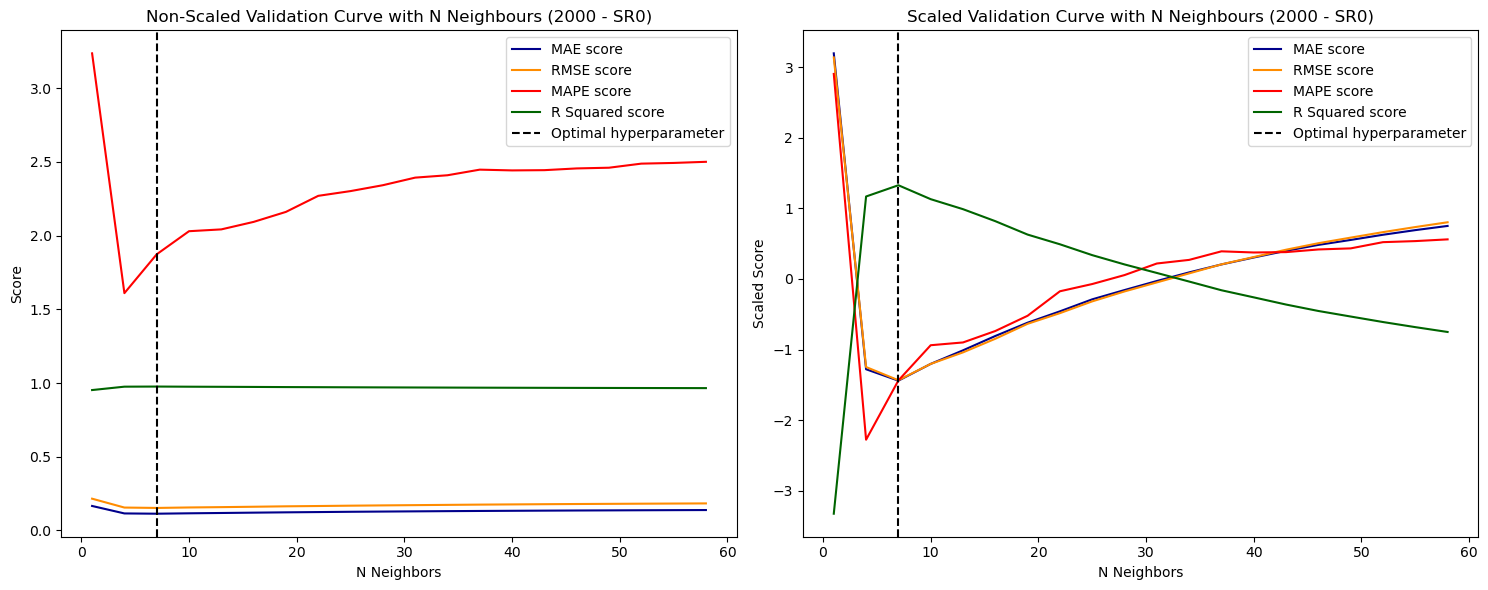

In [37]:
n_neighbors = 7
df = pd.DataFrame(cv_score_list_2000_n).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(n_neighbors_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(n_neighbors_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(n_neighbors_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(n_neighbors_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('N Neighbors')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with N Neighbours (2000 - SR0)")

# Plot normalized data on the second subplot
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('N Neighbors')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with N Neighbours (2000 - SR0)")

plt.tight_layout()
plt.show()

## Validation score as calibration set size increases

In [52]:
def calculate_means(data_structures):
    all_means = {}
    for structure_id, data in enumerate(data_structures, 1):
        means = {key: sum(d[key] for d in data.values()) / len(data) for key in data[next(iter(data))]}
        all_means[f"Structure {structure_id}"] = means
    return all_means

# List of data structures
data_structures_n = [cv_score_list_200_n, cv_score_list_400_n, cv_score_list_600_n, cv_score_list_800_n,cv_score_list_1000_n,cv_score_list_1500_n, cv_score_list_2000_n]
data_structures_power = [cv_score_list_200_power, cv_score_list_400_power, cv_score_list_600_power,cv_score_list_800_power,cv_score_list_1000_power,cv_score_list_1500_power, cv_score_list_2000_power]

# Calculate means
all_means_n = calculate_means(data_structures_n)
all_means_power = calculate_means(data_structures_power)

In [53]:
new_keys = [200, 400, 600, 800, 1000, 1500, 2000]

# Function to replace keys
def replace_keys(structures, new_keys):
    # Make sure there are enough new keys for the structures
    if len(new_keys) < len(structures):
        raise ValueError("Not enough new keys for the number of structures")

    # New dictionary to store replaced key structures
    replaced_structures = {}

    # Use zip to iterate over both the items in structures and the new_keys simultaneously
    for new_key, (old_key, value) in zip(new_keys, structures.items()):
        replaced_structures[new_key] = value

    return replaced_structures

all_means_n = replace_keys(all_means_n, new_keys)
all_means_power = replace_keys(all_means_power, new_keys)

In [54]:
cal_size = [200, 400, 600, 800, 1000, 1500, 2000]
all_means_power_df = pd.DataFrame(all_means_power).T
all_means_n_df = pd.DataFrame(all_means_n).T
all_means_n_df

,Validation Score MAE,Validation Score RMSE,Validation Score MAPE,Validation Score R Squared
200,0.360697,0.475250,6.266078,0.766861
400,0.256532,0.350368,4.535730,0.873222
600,0.221829,0.305231,4.552543,0.903866
800,0.198654,0.270887,2.359443,0.924248
1000,0.176550,0.238306,2.309661,0.941284
1500,0.148732,0.202198,2.556699,0.957695
2000,0.129723,0.172235,2.324853,0.969269


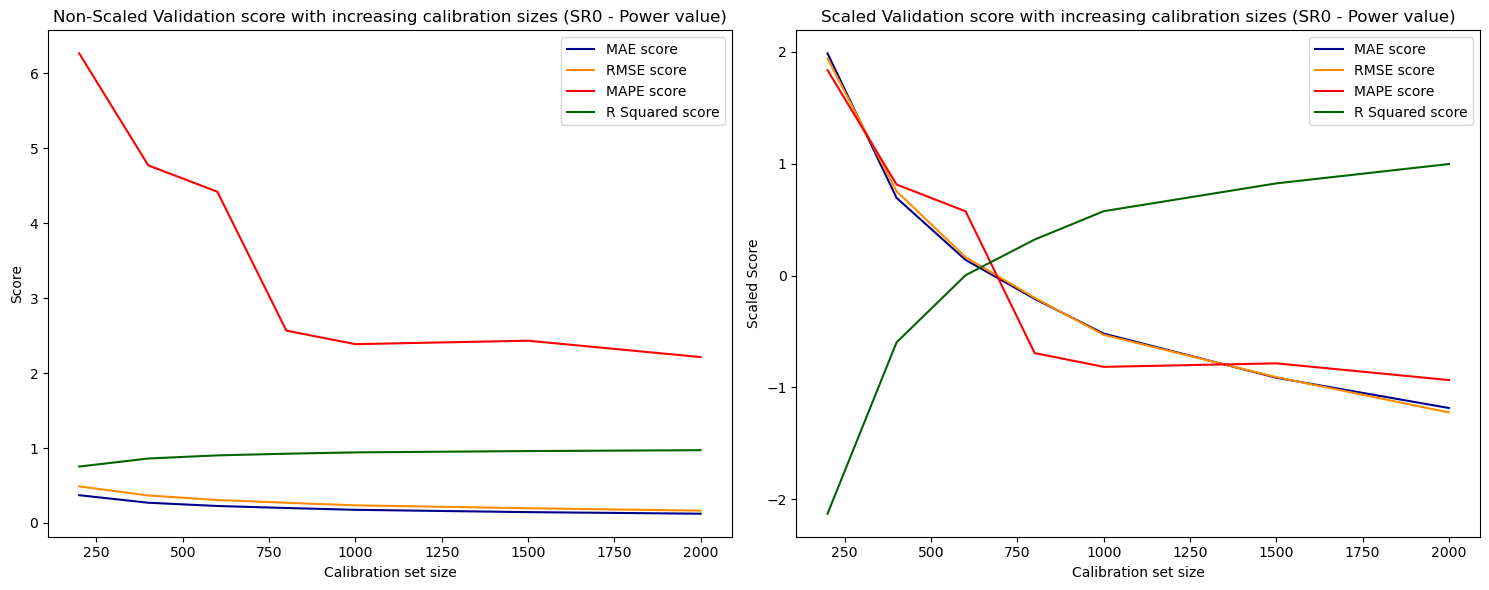

In [55]:
# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(all_means_power_df), columns=all_means_power_df.columns, index=all_means_power_df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(cal_size, all_means_power_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(cal_size, all_means_power_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(cal_size, all_means_power_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(cal_size, all_means_power_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].set_xlabel('Calibration set size')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation score with increasing calibration sizes (SR0 - Power value)")

# Plot normalized data on the second subplot
ax[1].plot(cal_size, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(cal_size, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(cal_size, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(cal_size, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].set_xlabel('Calibration set size')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation score with increasing calibration sizes (SR0 - Power value)")

plt.tight_layout()
plt.show()

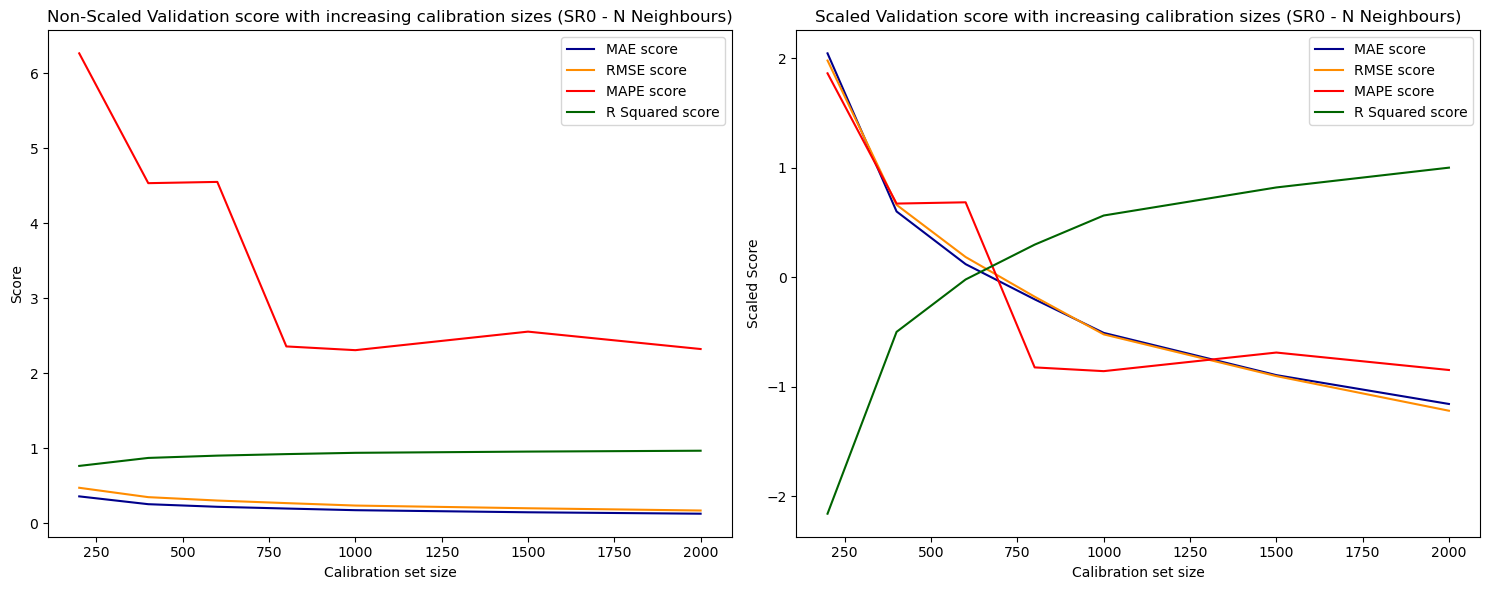

In [51]:
# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(all_means_n_df), columns=all_means_n_df.columns, index=all_means_n_df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(cal_size, all_means_n_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(cal_size, all_means_n_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(cal_size, all_means_n_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(cal_size, all_means_n_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].set_xlabel('Calibration set size')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation score with increasing calibration sizes (SR0 - N Neighbours)")

# Plot normalized data on the second subplot
ax[1].plot(cal_size, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(cal_size, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(cal_size, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(cal_size, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].set_xlabel('Calibration set size')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation score with increasing calibration sizes (SR0 - N Neighbours)")

plt.tight_layout()
plt.show()

## Testing model (Final Performance Metrics)

In [56]:
filenames = ['SR0_input_randomfield_cal200','SR0_input_randomfield_cal400', 'SR0_input_randomfield_cal600',
             'SR0_input_randomfield_cal800', 'SR0_input_randomfield_cal1000', 'SR0_input_randomfield_cal1500', 'SR0_input_randomfield_cal2000']
#cal_SR0_input_randomfield_cal2000.csv
combined_df = pd.DataFrame()
for file in filenames:
    cal_df = pd.read_csv(f'Synthetic Data/SR0/cal_{file}.csv')
    combined_df = pd.concat([cal_df, combined_df], ignore_index=True)

combined_df = pd.concat([val_df, combined_df], ignore_index=True)
combined_df = combined_df.drop_duplicates() #The calibration sets are subsets of one another, hence needed

combined_df #All caliration points and validation data points

,x,y,z
0,39,4,-0.520793
1,47,42,-0.373555
2,92,88,0.003110
3,24,43,-0.232004
4,37,92,-0.116758
...,...,...,...
3995,93,12,-3.031762
3996,56,25,0.305903
3997,22,8,-1.150329
3998,38,35,-0.539275


In [57]:
eval_combined_array_coordinates = np.array([list(pair) for pair in zip(combined_df['x'], combined_df['y'])])

start_time = time.time()

idw_model = ShepardIDWInterpolator(eval_combined_array_coordinates, combined_df['z'])

 # Predict at test locations
eval_combined_array_test = np.array([list(pair) for pair in zip(test_df['x'], test_df['y'])])
z_pred_test = idw_model.__call__(eval_combined_array_test, power = 3, n_neighbors = 7)

rmse = np.sqrt(mean_squared_error(test_df['z'], z_pred_test))
mae = mean_absolute_error(test_df['z'], z_pred_test)
mape = mean_absolute_percentage_error(test_df['z'], z_pred_test)
r2 = r2_score(test_df['z'], z_pred_test)

end_time = time.time()

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R Squared:", r2)
print(f"Testing Computation Time: {end_time - start_time:.2f} seconds")

MAE: 0.07278041174461998
RMSE: 0.09916811124149831
MAPE: 0.3829123192142194
R Squared: 0.9900818606786401
Testing Computation Time: 0.11 seconds


### Plotting Spatial Interpolation of entire area with Model

In [58]:
filenames = ['cal_SR0_input_randomfield_cal200', 'cal_SR0_input_randomfield_cal400', 'cal_SR0_input_randomfield_cal600', 'cal_SR0_input_randomfield_cal800', 'cal_SR0_input_randomfield_cal1000', 'cal_SR0_input_randomfield_cal1500', 'cal_SR0_input_randomfield_cal2000',
            'val_SR0_input_randomfield_cal2000', 'test_SR0_input_randomfield_cal2000']
#cal_SR0_input_randomfield_cal2000.csv
all_df = pd.DataFrame()
for file in filenames:
    df = pd.read_csv(f'Synthetic Data/SR0/{file}.csv')
    all_df = pd.concat([df, all_df], ignore_index=True)

all_df = all_df.drop_duplicates() #The calibration sets are subsets of one another, hence needed

all_df #All calbration, validation and test data points

,x,y,z
0,83,56,-0.838066
1,40,74,-0.436379
2,90,28,-0.031699
3,51,84,-0.388236
4,32,48,-1.099538
...,...,...,...
5995,93,12,-3.031762
5996,56,25,0.305903
5997,22,8,-1.150329
5998,38,35,-0.539275


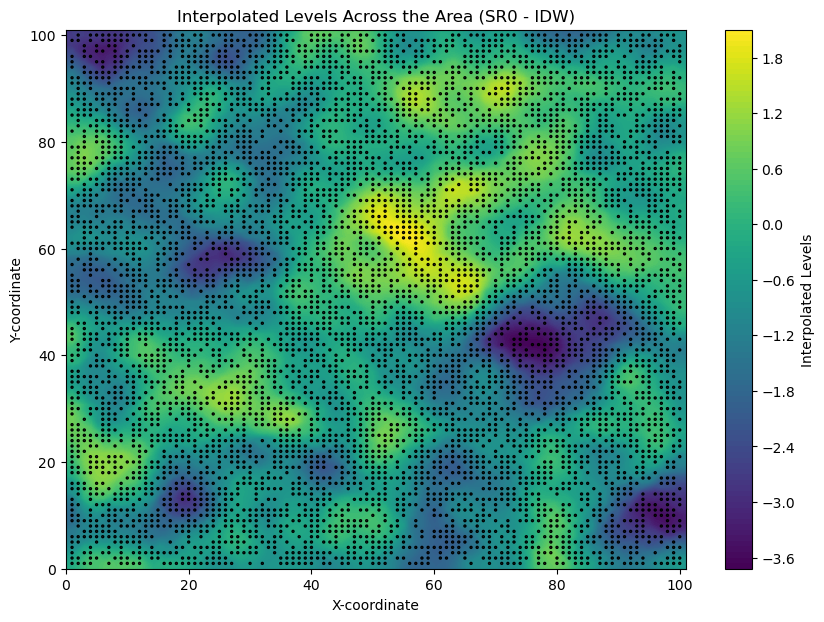

Spatial Interpolation Computation Time: 0.24 seconds


In [59]:
# Using full set: Convert columns to numpy arrays
observed_location_columns = ['x', 'y']
observed_values_column = 'z'
observed_locations = all_df[observed_location_columns].values
observed_values = all_df[observed_values_column].values

# Initialize IDW model
idw_model = ShepardIDWInterpolator(observed_locations, observed_values)

# Start timing spatial interpolation
start_time_interpolation = time.time()

x_min, x_max = observed_locations[:, 0].min() - 1, observed_locations[:, 0].max() + 1
y_min, y_max = observed_locations[:, 1].min() - 1, observed_locations[:, 1].max() + 1
x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Interpolate values
interpolated_values = idw_model.__call__(grid_points, power = 3, n_neighbors = 7)
z_grid = interpolated_values.reshape(x_grid.shape)

end_time_interpolation = time.time()  # End timing spatial interpolation

# Visualization
plt.figure(figsize=(10, 7))
plt.contourf(x_grid, y_grid, z_grid, cmap='viridis', levels=100)
plt.colorbar(label='Interpolated Levels')
plt.scatter(all_df['x'], all_df['y'], c=all_df['z'], cmap='viridis', edgecolor='k', label='Observed', s= 2.0)
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
#plt.legend()
plt.title('Interpolated Levels Across the Area (SR0 - IDW)')
plt.show()

print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")